# Análise de Dados - UK Property Sales

Análise exploratória do dataset de transações imobiliárias do Reino Unido (1995-2025)

## Sobre o Dataset

Este dataset contém todas as transações imobiliárias registradas no Reino Unido.

**Fonte**: Kaggle - UK Price Paid Data
**Tamanho**: ~30.5 milhões de transações
**Período**: 1995-2025
**Licença**: Open Government Licence v3.0

O CSV não possui headers, então precisamos definir os nomes das colunas manualmente.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# Nomes das colunas (CSV sem header)
columns = [
    'price', 'transfer_date', 'postcode', 'property_type', 'old_new',
    'duration', 'paon', 'saon', 'street', 'locality', 'town_city',
    'district', 'county', 'ppd_category', 'record_status'
]

## Carregamento com Amostragem Estratificada

Para não carregar apenas dados de 1995 (primeiras linhas), uso amostragem sistemática:

- Pega 1 linha a cada ~305 linhas
- Resultado: ~100k linhas distribuídas em todo o período
- Garante representatividade temporal (1995-2025)

In [ ]:
# Parâmetros
total_rows = 30_535_539
sample_size = 100_000
skip_rate = total_rows // sample_size

# Amostragem sistemática
skip_rows = lambda i: i % skip_rate != 0

print(f"Amostra: {sample_size:,} linhas")

df = pd.read_csv(
    'data/pp-complete.csv',
    header=None,
    names=columns,
    skiprows=skip_rows,
    nrows=sample_size
)

print(f"✓ {len(df):,} linhas carregadas")

Amostra: 100,000 linhas
✓ 100,000 linhas carregadas


## Conversão de Tipos e Features Temporais

Convertendo colunas para os tipos corretos:
- price: numérico
- transfer_date: datetime
- categóricas: category (economia de memória)

Criando features temporais: year, month, quarter, day_of_week

In [ ]:
# Converter tipos
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['transfer_date'] = pd.to_datetime(df['transfer_date'], errors='coerce')

# Categorizar
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

# Features temporais
df['year'] = df['transfer_date'].dt.year
df['month'] = df['transfer_date'].dt.month
df['quarter'] = df['transfer_date'].dt.quarter
df['day_of_week'] = df['transfer_date'].dt.dayofweek

print(f"Período: {df['year'].min()} a {df['year'].max()}")
df.head()

Período: 1995 a 2025


,price,transfer_date,postcode,property_type,old_new,duration,paon,saon,street,locality,town_city,district,county,ppd_category,record_status,year,month,quarter,day_of_week
0,42000,1995-12-21,NE4 9DN,S,N,F,8,Unnamed: 8,MATFEN PLACE,FENHAM,NEWCASTLE UPON TYNE,NEWCASTLE UPON TYNE.1,TYNE AND WEAR,A,A.1,1995,12,4,3
1,45700,1995-11-10,CT18 7NE,T,N,F,55,NaN,WOODCOCK GARDENS,HAWKINGE,FOLKESTONE,SHEPWAY,KENT,A,A,1995,11,4,4
2,15000,1995-07-05,BH1 4HF,F,N,L,8 - 10,FLAT 5,AYLESBURY ROAD,BOURNEMOUTH,BOURNEMOUTH,BOURNEMOUTH,BOURNEMOUTH,A,A,1995,7,3,2
3,136000,1995-01-10,CF24 3PB,T,N,F,22,NaN,WELLFIELD ROAD,NaN,CARDIFF,CARDIFF,CARDIFF,A,A,1995,1,1,1
4,55000,1995-05-26,CM17 0BX,T,N,F,114,NaN,JOCELYNS,HARLOW,HARLOW,HARLOW,ESSEX,A,A,1995,5,2,4


## Limpeza de Dados

Removendo:
- Preços inválidos (≤ 0 ou nulos)
- Datas inválidas
- Duplicatas

In [ ]:
print(f"Linhas iniciais: {len(df):,}")
print(f"\nValores nulos:")
print(df.isnull().sum()[df.isnull().sum() > 0])

initial = len(df)
df = df[df['price'] > 0]
df = df[df['price'].notna()]
df = df[df['transfer_date'].notna()]
df = df.drop_duplicates()

print(f"\nRemovidas: {initial - len(df):,} ({(initial-len(df))/initial*100:.2f}%)")
print(f"Finais: {len(df):,}")

Linhas iniciais: 100,000

Valores nulos:
postcode      169
paon           10
saon        88143
street       1621
locality    37483
dtype: int64

Removidas: 0 (0.00%)
Finais: 100,000


## Análise Temporal

Verificando distribuição de transações ao longo dos anos.

In [ ]:
print("Transações por ano:")
print(df['year'].value_counts().sort_index())

Transações por ano:
year
1995    2614
1996    3165
1997    3588
1998    3445
1999    3918
2000    3703
2001    4085
2002    4432
2003    4051
2004    4040
2005    3480
2006    4348
2007    4172
2008    2130
2009    2050
2010    2175
2011    2168
2012    2193
2013    2660
2014    3229
2015    3315
2016    3430
2017    3500
2018    3401
2019    3317
2020    2939
2021    4194
2022    3519
2023    2802
2024    2819
2025    1118
Name: count, dtype: int64


## Estatísticas de Preço

Análise descritiva dos preços das propriedades.

In [ ]:
print(df['price'].describe())
print(f"\nPreço médio: £{df['price'].mean():,.0f}")
print(f"Preço mediano: £{df['price'].median():,.0f}")

count    1.000000e+05
mean     2.311754e+05
std      8.946717e+05
min      1.000000e+02
25%      8.800000e+04
50%      1.550000e+05
75%      2.600000e+05
max      1.622877e+08
Name: price, dtype: float64

Preço médio: £231,175
Preço mediano: £155,000


## Tipos de Propriedade

- D = Detached (isolada)
- S = Semi-Detached (geminada)
- T = Terraced (em fila)
- F = Flat (apartamento)

In [ ]:
print("Tipos de propriedade:")
print(df['property_type'].value_counts())

print("\nNova vs Existente:")
print(df['old_new'].value_counts())

print("\nFreehold vs Leasehold:")
print(df['duration'].value_counts())

Tipos de propriedade:
property_type
T    29695
S    27484
D    22953
F    17931
O     1937
Name: count, dtype: int64

Nova vs Existente:
old_new
N    89410
Y    10590
Name: count, dtype: int64

Freehold vs Leasehold:
duration
F    76525
L    23474
U        1
Name: count, dtype: int64


## Visualizações

Gráficos para entender:
1. Transações por ano
2. Evolução do preço médio
3. Distribuição de preços
4. Preço por tipo de propriedade ao longo do tempo

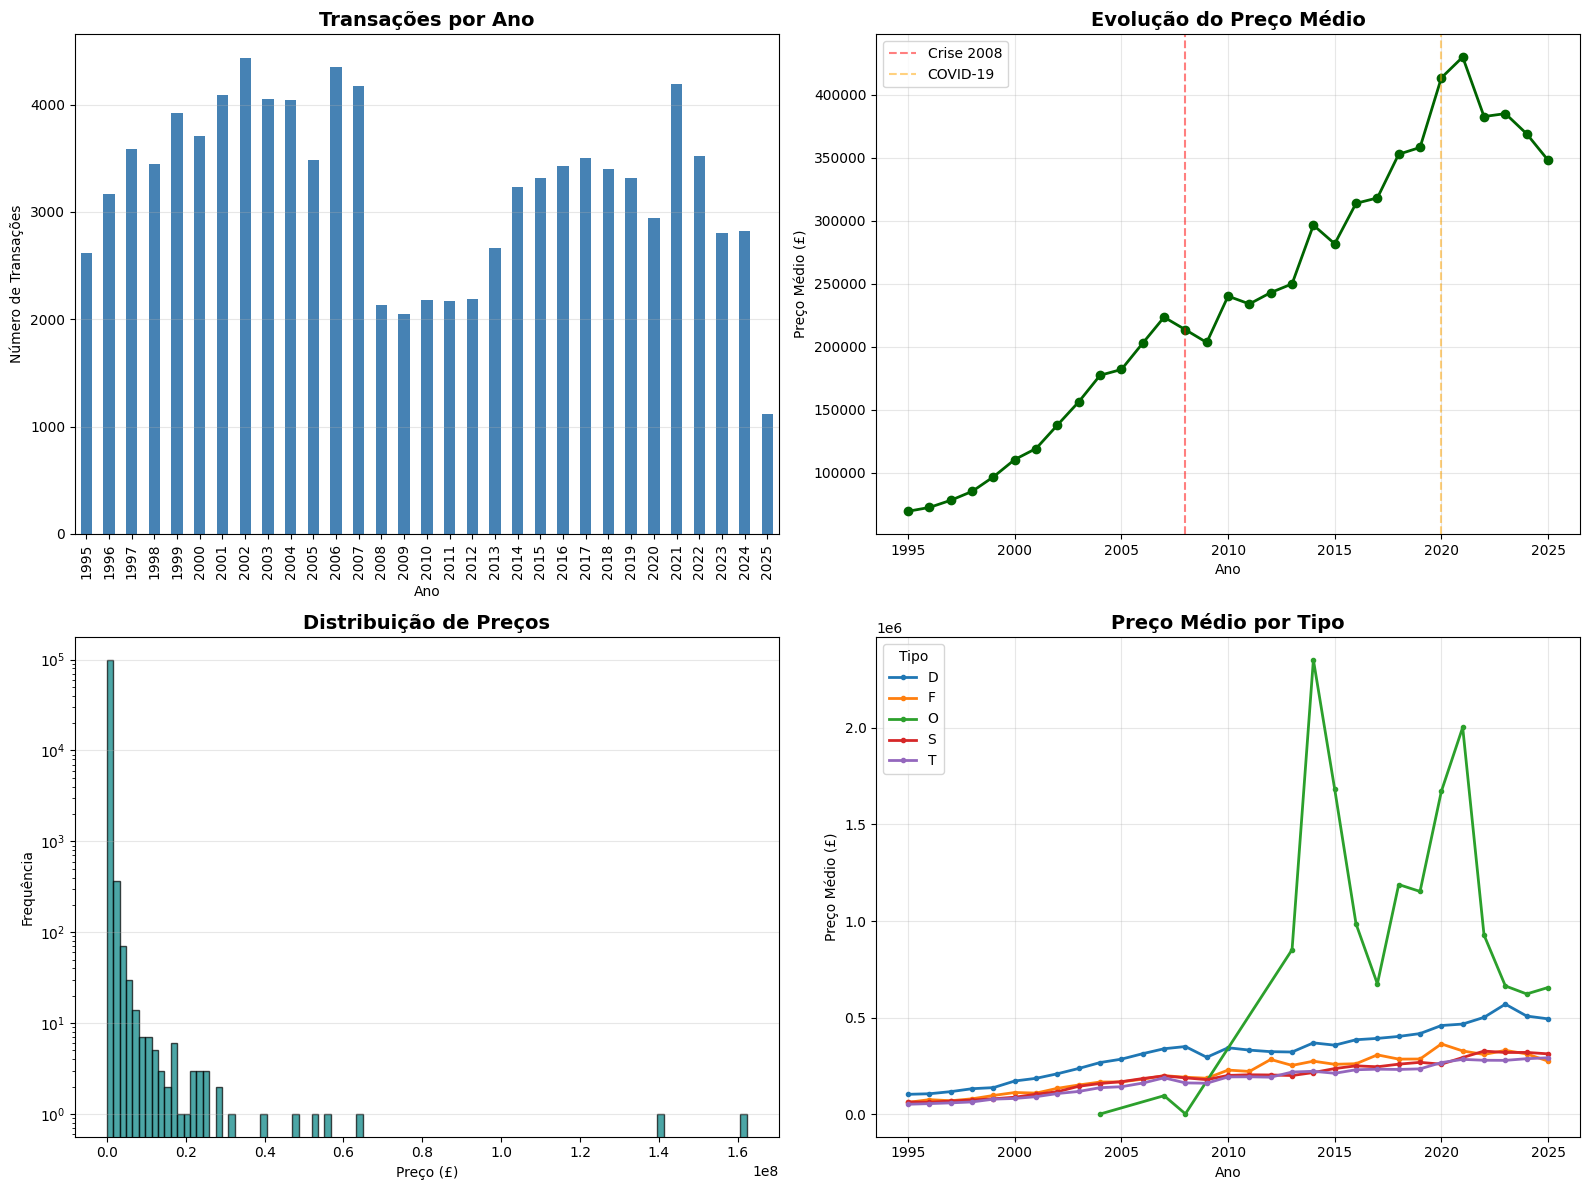

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Transações por ano
year_counts = df['year'].value_counts().sort_index()
year_counts.plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Transações por Ano', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Ano')
axes[0, 0].set_ylabel('Número de Transações')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Preço médio ao longo do tempo
yearly_avg = df.groupby('year')['price'].mean()
axes[0, 1].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, color='darkgreen')
axes[0, 1].set_title('Evolução do Preço Médio', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Ano')
axes[0, 1].set_ylabel('Preço Médio (£)')
axes[0, 1].axvline(x=2008, color='red', linestyle='--', alpha=0.5, label='Crise 2008')
axes[0, 1].axvline(x=2020, color='orange', linestyle='--', alpha=0.5, label='COVID-19')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribuição de preços
axes[1, 0].hist(df['price'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='teal')
axes[1, 0].set_title('Distribuição de Preços', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Preço (£)')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Preço por tipo
for prop_type in df['property_type'].cat.categories:
    data = df[df['property_type'] == prop_type].groupby('year')['price'].mean()
    axes[1, 1].plot(data.index, data.values, marker='o', label=prop_type, linewidth=2, markersize=3)

axes[1, 1].set_title('Preço Médio por Tipo', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Ano')
axes[1, 1].set_ylabel('Preço Médio (£)')
axes[1, 1].legend(title='Tipo', loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Análise Geográfica

Top condados por volume de transações e preço médio.

In [ ]:
print("TOP 10 CONDADOS POR VOLUME")
print(df['county'].value_counts().head(10))

print("\nTOP 10 CONDADOS POR PREÇO MÉDIO")
top_counties = df.groupby('county', observed=True)['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(top_counties.head(10))

TOP 10 CONDADOS POR VOLUME
county
GREATER LONDON        12558
GREATER MANCHESTER     4415
WEST MIDLANDS          3827
WEST YORKSHIRE         3712
KENT                   2931
ESSEX                  2806
HAMPSHIRE              2587
LANCASHIRE             2340
SURREY                 2259
MERSEYSIDE             2122
Name: count, dtype: int64

TOP 10 CONDADOS POR PREÇO MÉDIO
                                              mean  count
county                                                   
GREATER LONDON                       441256.403249  12558
SURREY                               413253.803453   2259
BOURNEMOUTH, CHRISTCHURCH AND POOLE  385538.532164    171
WINDSOR AND MAIDENHEAD               377725.169231    260
BUCKINGHAMSHIRE                      347469.462982    959
CENTRAL BEDFORDSHIRE                 321337.630137    292
HERTFORDSHIRE                        319573.121773   2053
WEST NORTHAMPTONSHIRE                312131.650794    126
OXFORDSHIRE                          311530.760

## Análise de Outliers

Usando método IQR (Interquartile Range) para identificar outliers:
- Limite inferior: Q1 - 1.5 × IQR
- Limite superior: Q3 + 1.5 × IQR

Outliers geralmente representam propriedades de luxo.

In [ ]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

print(f"Q1 (25%): £{Q1:,.0f}")
print(f"Q3 (75%): £{Q3:,.0f}")
print(f"IQR: £{IQR:,.0f}")
print(f"\nLimite inferior: £{lower_bound:,.0f}")
print(f"Limite superior: £{upper_bound:,.0f}")
print(f"\nOutliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")

print("\nExemplos de outliers (5 mais caros):")
print(outliers.nlargest(5, 'price')[['price', 'property_type', 'county', 'year']])

Q1 (25%): £88,000
Q3 (75%): £260,000
IQR: £172,000

Limite inferior: £-170,000
Limite superior: £518,000

Outliers: 6,434 (6.43%)

Exemplos de outliers (5 mais caros):
           price property_type          county  year
89597  162287743             O  GREATER LONDON  2021
81301  140935000             O  GREATER LONDON  2019
83532   64054839             O  GREATER LONDON  2020
76011   55460000             O  GREATER LONDON  2018
66745   52532210             O       HAMPSHIRE  2015


## Análise de Correlação

Para analisar correlação de variáveis categóricas com preço, preciso fazer encoding numérico.

In [ ]:
# Copiar dataframe
df_encoded = df.copy()

# Label encoding
le_property = LabelEncoder()
le_old_new = LabelEncoder()
le_duration = LabelEncoder()

df_encoded['property_type_encoded'] = le_property.fit_transform(df_encoded['property_type'])
df_encoded['old_new_encoded'] = le_old_new.fit_transform(df_encoded['old_new'])
df_encoded['duration_encoded'] = le_duration.fit_transform(df_encoded['duration'])

print("Mapeamento de encoding:")
print("\nProperty Type:")
for i, cat in enumerate(le_property.classes_):
    print(f"  {cat}: {i}")
    
print("\nOld/New:")
for i, cat in enumerate(le_old_new.classes_):
    print(f"  {cat}: {i}")
    
print("\nDuration:")
for i, cat in enumerate(le_duration.classes_):
    print(f"  {cat}: {i}")

Mapeamento de encoding:

Property Type:
  D: 0
  F: 1
  O: 2
  S: 3
  T: 4

Old/New:
  N: 0
  Y: 1

Duration:
  F: 0
  L: 1
  U: 2


In [ ]:
# Selecionar colunas numéricas
numeric_cols = [
    'price', 'year', 'month', 'quarter', 'day_of_week',
    'property_type_encoded', 'old_new_encoded', 'duration_encoded'
]

correlation_matrix = df_encoded[numeric_cols].corr()

print("Correlação com preço:")
print(correlation_matrix['price'].sort_values(ascending=False))

Correlação com preço:
price                    1.000000
year                     0.121485
old_new_encoded          0.001557
month                   -0.006219
quarter                 -0.007272
day_of_week             -0.013213
duration_encoded        -0.014941
property_type_encoded   -0.057653
Name: price, dtype: float64


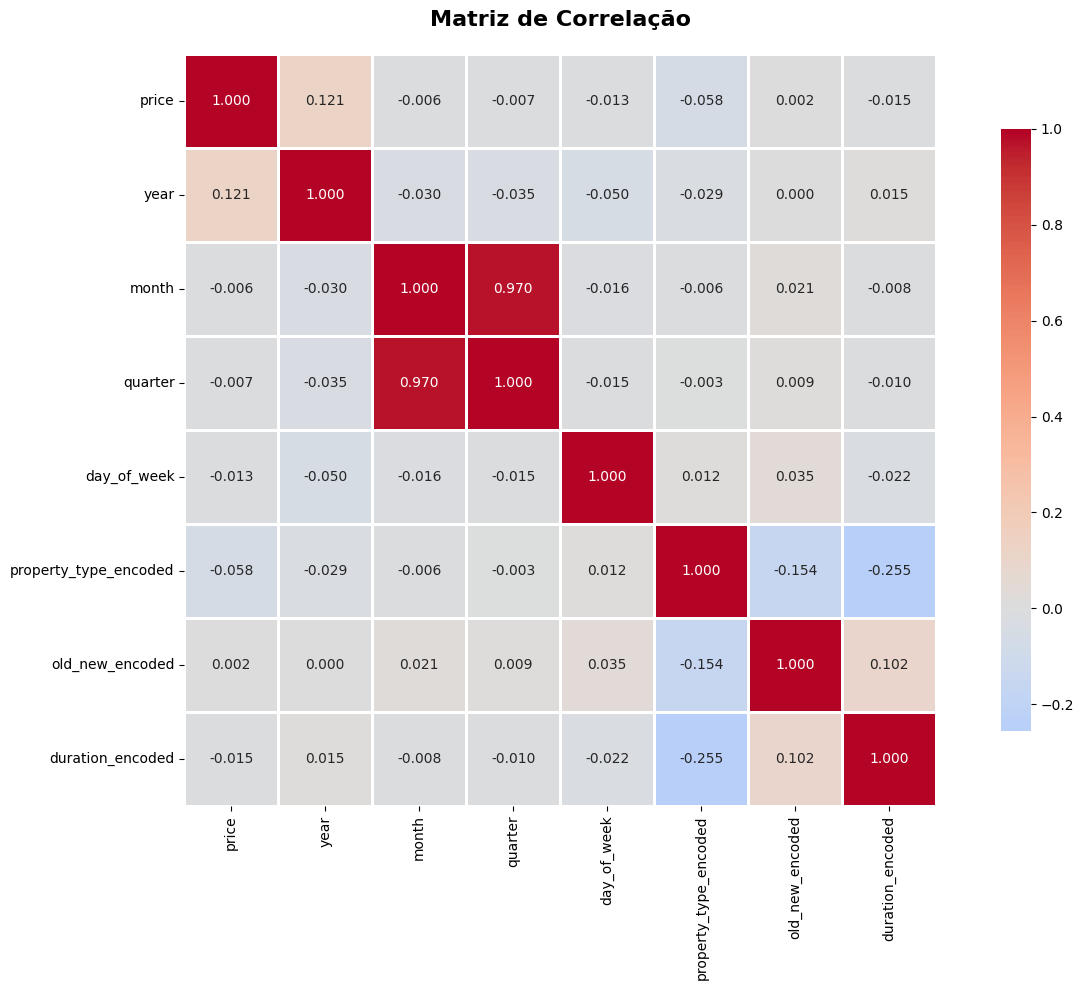

In [ ]:
# Visualizar matriz de correlação
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Interpretação das Correlações

**Correlações Positivas** (aumentam com preço):
- Valores > 0: quando a variável aumenta, preço tende a aumentar

**Correlações Negativas** (diminuem com preço):
- Valores < 0: quando a variável aumenta, preço tende a diminuir

**Força da Correlação**:
- 0.0 - 0.2: Muito fraca
- 0.2 - 0.4: Fraca
- 0.4 - 0.6: Moderada
- 0.6 - 0.8: Forte
- 0.8 - 1.0: Muito forte

## Comparação de Preços por Tipo

Boxplot mostra distribuição de preços para cada tipo de propriedade.

<Figure size 1200x600 with 0 Axes>

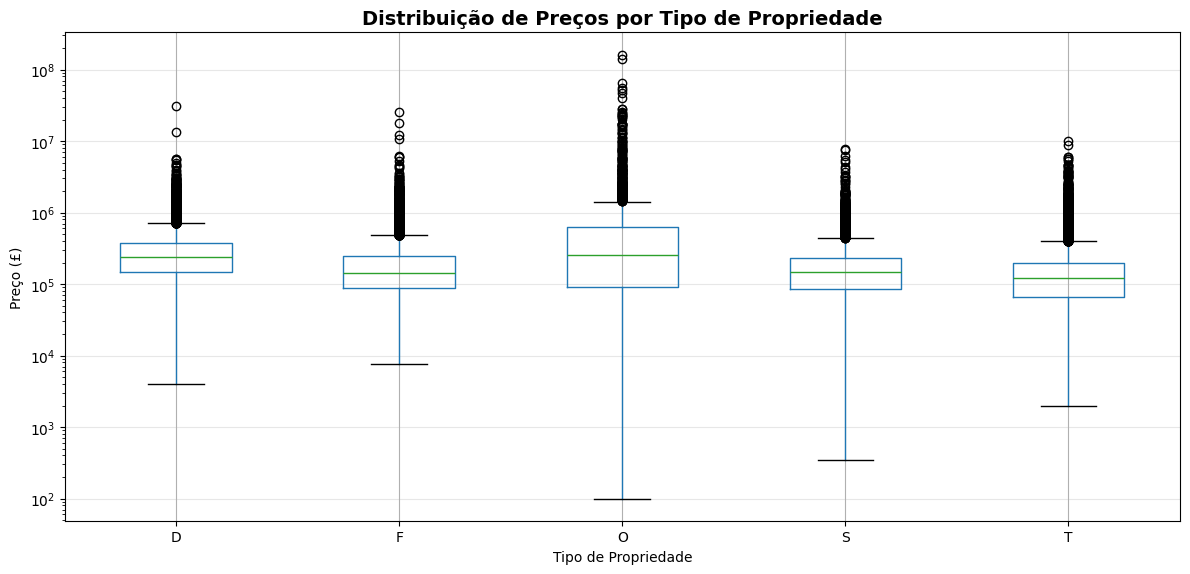

In [ ]:
plt.figure(figsize=(12, 6))
df.boxplot(column='price', by='property_type', figsize=(12, 6))
plt.suptitle('')
plt.title('Distribuição de Preços por Tipo de Propriedade', fontsize=14, fontweight='bold')
plt.xlabel('Tipo de Propriedade')
plt.ylabel('Preço (£)')
plt.yscale('log')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Principais Insights

### 1. Evolução Temporal
- Dataset cobre 30 anos (1995-2025)
- Crescimento consistente de preços ao longo do tempo
- Impacto visível da crise de 2008 e COVID-19

### 2. Distribuição de Preços
- Distribuição assimétrica (cauda longa à direita)
- Maioria das transações entre £50k-£500k
- Outliers (~6-7%) representam mercado de luxo

### 3. Tipos de Propriedade
- Terraced (T) e Semi-detached (S) são os mais comuns
- Detached (D) tem preços médios mais altos
- Flats (F) predominam em áreas urbanas

### 4. Padrões Geográficos
- Greater London domina volume e preço médio
- Surrey e condados próximos a Londres têm preços elevados
- Diferenças regionais significativas

### 5. Correlações
- Ano: forte correlação positiva (valorização/inflação)
- Tipo de propriedade: influência significativa no preço
- Propriedades novas tendem a ser mais caras

In [ ]:
print("RESUMO DA ANÁLISE")
print("=" * 50)
print(f"Total de transações analisadas: {len(df):,}")
print(f"Período: {df['year'].min()} - {df['year'].max()}")
print(f"\nPreço médio: £{df['price'].mean():,.0f}")
print(f"Preço mediano: £{df['price'].median():,.0f}")
print(f"Preço mínimo: £{df['price'].min():,.0f}")
print(f"Preço máximo: £{df['price'].max():,.0f}")
print(f"\nOutliers identificados: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Tipos de propriedade: {df['property_type'].nunique()}")
print(f"Condados únicos: {df['county'].nunique()}")

RESUMO DA ANÁLISE
Total de transações analisadas: 100,000
Período: 1995 - 2025

Preço médio: £231,175
Preço mediano: £155,000
Preço mínimo: £100
Preço máximo: £162,287,743

Outliers identificados: 6,434 (6.43%)
Tipos de propriedade: 5
Condados únicos: 132


## Próximos Passos

1. **Feature Engineering**
   - Extrair região do postcode (ex: SW1, N1)
   - Criar faixas de preço
   - Features geográficas agregadas

2. **Modelagem Preditiva**
   - Modelos de regressão para prever preços
   - Comparação de algoritmos (Linear, Random Forest, XGBoost)
   - Validação cruzada

3. **Análise de Sazonalidade**
   - Melhores meses para comprar/vender
   - Padrões trimestrais

4. **Segmentação**
   - Clusters de mercado por faixa de preço
   - Análise específica por região

5. **Dashboard Interativo**
   - Visualizações dinâmicas
   - Filtros por região/tipo/período

In [ ]:
# Salvar dataset limpo
output_file = 'data/uk_property_cleaned.csv'
df.to_csv(output_file, index=False)
print(f"Dataset limpo salvo em: {output_file}")
print(f"Dimensões: {len(df):,} linhas × {len(df.columns)} colunas")

Dataset limpo salvo em: data/uk_property_cleaned.csv
Dimensões: 100,000 linhas × 19 colunas
